In [207]:
import tensorflow as tf
import os

In [208]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Import the Data

In [209]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [210]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [211]:
data_dir = 'data' 
# All of the extensions we are familiar with
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [212]:
# Get rid of all of the bad images using opencv
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

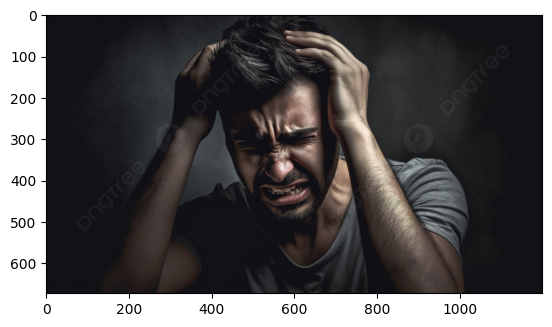

In [213]:
img = cv2.imread(os.path.join("data", "sad", "pngtree-sad-man-is-holding-his-face-and-is-holding-his-head-picture-image_3160446.jpg"))
#Fix Colour and plots it
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Load Data

In [214]:
# We use built in keras pipeline
# REAAAAAALLLY USEFUL (builds classes)
# We can adapt the batch sizes, image size ...
data = tf.keras.utils.image_dataset_from_directory("data")

Found 182 files belonging to 2 classes.


In [215]:
# Allows to iterate through the data / access data pipeline
data_iterator = data.as_numpy_iterator()

In [216]:
#Actually grabs a batch
batch = data_iterator.next()
# There is 2 parts to this the image itself and the lables batch at pos 0, lables at pos 1
# If it doesnt work run again data_iterator
data.as_numpy_iterator().next()[0].max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.72461].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..245.12085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..241.48242].


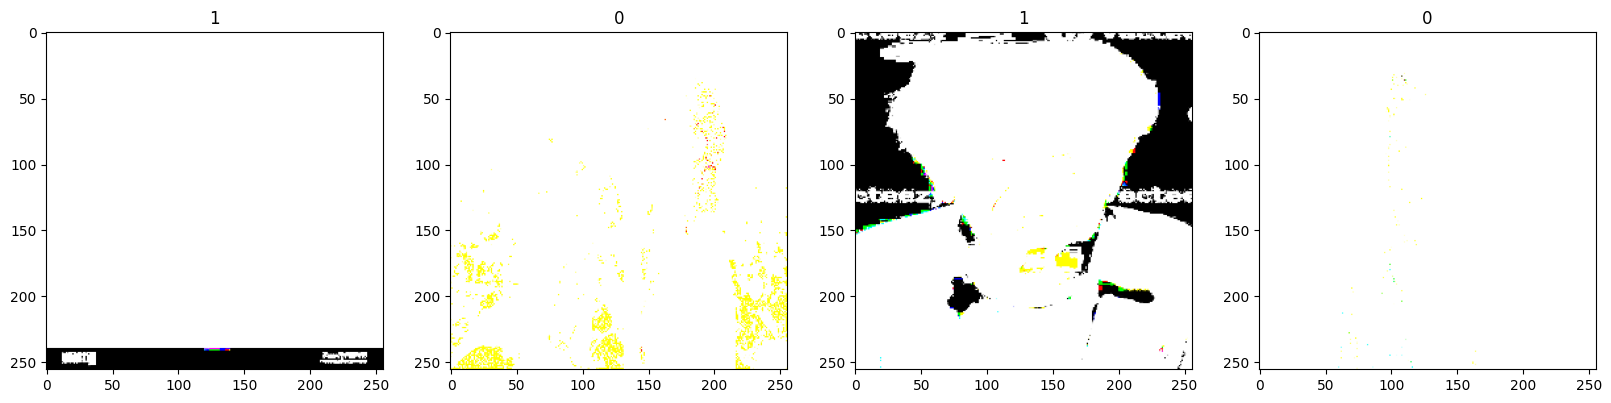

In [217]:
# We can use this to check out batches, 1 sad ppl, 0 happy ppl
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2 - Preprocessing

In [218]:
# Scale values between 0 and 1, data .map allows us to do the transformation, x is the data and y is the lable, the scaling is 255
data = data.map(lambda x,y : (x/255, y))
# There are other transformations that can also be used at tensorflow web (we are using map)

In [219]:
# If we didnt have shuffling this would retrun the same things all the time
data.as_numpy_iterator().next()

(array([[[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [9.9813581e-01, 9.9813581e-01, 9.9813581e-01],
          [1.0000000e+00, 1.0000000e+

Split Data

In [220]:
len(data)
# We have this amount of batches and each batch is going to have 32 images

6

In [221]:
train_size = int(len(data)*.7) # Train
val_size = int(len(data)*.2) # Evaluate as we train
test_size = int(len(data)* 0.1)+1 # Test once the model has been trained

In [222]:
# We will use the take and skip library from tensorflow, we can do this directrly because our data is already shuffled

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)    

Build Deep Learning Model

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [224]:
model = Sequential()

In [225]:
# We are passing the outcomes thought the activations to reshape the output

# Filters, shape, stride, activation, input_shape
model.add(Conv2D(16, (3,3), 1, activation = "relu", input_shape=(256,256,3)))
model.add(MaxPooling2D()) # Condenses the informatioh

model.add(Conv2D(32, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten()) # We flatten so we can Dense the final Layer, fully connected/ Dense layer

model.add(Dense(256, activation = "relu"))
model.add(Dense(1, activation= "sigmoid")) 

C:\Users\20212464\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [226]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])
# There are many optimizers, can check with tf.optimizers.

In [227]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [228]:
# Train
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [229]:
hist = model.fit(train, epochs=20, validation_data =val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 0.6427 - loss: 2.6094 - val_accuracy: 0.4688 - val_loss: 2.0406
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.4479 - loss: 1.8006 - val_accuracy: 0.4062 - val_loss: 0.7659
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.4594 - loss: 0.7224 - val_accuracy: 0.7188 - val_loss: 0.6804
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.5635 - loss: 0.6867 - val_accuracy: 0.5312 - val_loss: 0.6840
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.5365 - loss: 0.6843 - val_accuracy: 0.6562 - val_loss: 0.6424
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.5604 - loss: 0.6782 - val_accuracy: 0.5938 - val_loss: 0.6479
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.6229 - loss: 0.6303 - val_accuracy: 0.7188 - val_loss: 0.6096
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.6469 - loss: 0.6329 - val_accuracy: 0.6250 - val_loss:

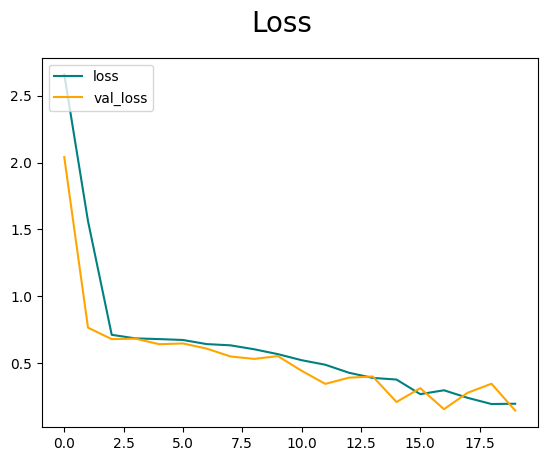

In [230]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Check regularization if this dosn't go down


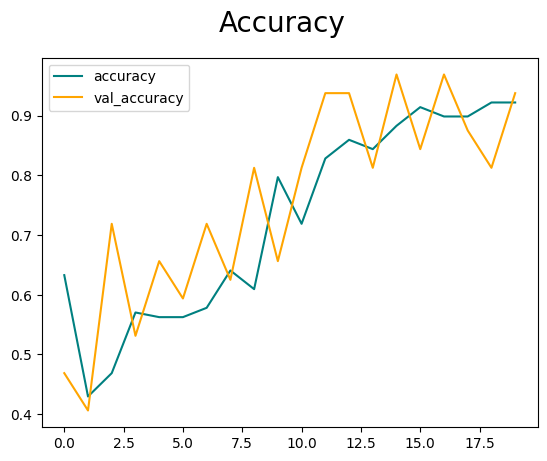

In [231]:
# Visualize Accuracy 
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluation

In [232]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np

In [233]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [234]:
for batch in test.as_numpy_iterator():
    X ,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [235]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


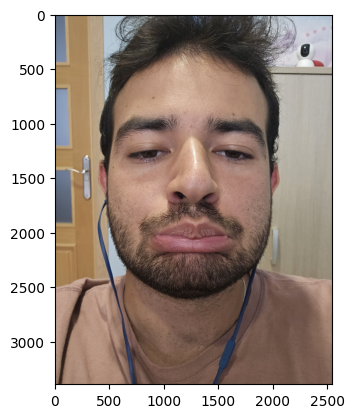

In [241]:
img = cv2.imread("Unseen/20240904_135323.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

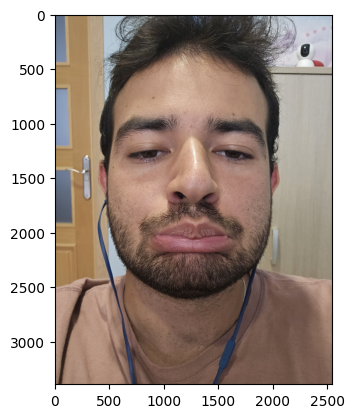

In [242]:
resize = tf.image.resize(img, (256,256)) # We have to resize for the model to be able to take it
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [243]:
np.expand_dims(resize, 0) # WE HAVE TO ENXAPSULATE IT WITH ANOTHER BATCH FOR THE MODEL TO BE ABLE TO TAKE IT

yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [244]:
yhat

array([[0.55074465]], dtype=float32)

Save the model

In [245]:
from tensorflow.keras.models import load_model

In [248]:
model.save(os.path.join("models","happysadmodel.h5")) #It is h5 for seraization for the model just like jpg for images

In [249]:
new_model = load_model(os.path.join("models","happysadmodel.h5"))

In [251]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([[0.55074465]], dtype=float32)